# Wetterstationen Konstanz

__Abgedeckter Zeitraum:__
*09/04/24 bis 31/12/24*

__Stationen:__
*Bodanplatz*, *Marktstätte*, *Herose Park*, *Mainaustraße*, *Staad (Fähre)*, *Hörnle*,  
*Friedrichstrasse*, *Europapark*, *Stadtgarten*, *Riedstrasse*, *Döbele*, *Stephansplatz*

__Zu klären:__
- *Daten Quali - wieviele fehlende Werte gibt es? gibt es unplausible Werte?*
- *Welche Zeiträume wären möglich/nutzbar für die Story?*
- *Was wollen wir für die Evaluation von möglichen Zeiträumen prioriseren? Möglichst vollständige/unverzerrte Messungen ohne Ausfälle? Möglichst viele Stationen? Möglichst spannende Zeit im Jahr (Hochsommer)?*
- *Wie machen wir unseren Punkt zur unterschiedlichen Temperaturentwicklung an unterschiedlichen Wetterstationen (städtebauliches Argument, grün/am wasser = kühler an heißen tagen, industrie/versiegelt = schneller aufgehitzt)? Vorher kategorisieren und vergleichen oder clustern als Möglichkeit?*

__Grade offen:__

- *Sommerzeit/Winterzeit mitbedenken*
- *Ausreißeranalyse*


#### Preprocessing

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ws = pd.read_csv('/Users/maite/Downloads/data_weather_stations_2024.csv')
ws.head()

,entity_id,name,dateobserved,atmosphericpressure,precipitation,relativehumidity,temperature,winddirection,windspeedavg,windspeedmax,windspeedmin,surfacetemperaturewintersense,temperaturewintersense
0,urn:ngsi-ld:WeatherObserved:eui-8cf95720000d35...,Marktstätte,2024-12-31 23:58:54.822+01,982.5,0.22,98.2,-1.6,28,0.4,1.1,0.1,0.27,-1.6309
1,urn:ngsi-ld:WeatherObserved:eui-8cf95720000d2f...,Herose-Park,2024-12-31 23:55:11.541+01,982.3,0.09,100.0,-1.3,203,0.6,1.0,0.1,NaN,NaN
2,urn:ngsi-ld:WeatherObserved:eui-8cf95720000d34...,Mainaustrasse,2024-12-31 23:53:21.901+01,981.2,0.04,100.0,-1.6,232,0.2,0.3,0.0,NaN,NaN
3,urn:ngsi-ld:WeatherObserved:eui-8cf95720000d34...,Fähre Staad,2024-12-31 23:52:12.075+01,982.0,82.60,100.0,-1.7,260,0.2,0.6,0.0,NaN,NaN
4,urn:ngsi-ld:WeatherObserved:eui-8cf95720000d2f...,Hörnle,2024-12-31 23:51:25.294+01,981.7,0.00,100.0,-1.9,253,0.2,0.4,0.1,NaN,NaN


In [3]:
#noch anpassen, grade zu faul :)
ws['dateobserved'] = pd.to_datetime(ws['dateobserved'].str.split('[.+]', n=1).str[0])

#new variables: date, time, hour & week_of_year
ws['date'] = ws['dateobserved'].dt.date
ws['time'] = ws['dateobserved'].dt.time
ws['hour'] = ws['dateobserved'].dt.hour
ws['week_of_year'] = ws['dateobserved'].dt.isocalendar().week


#### Aggregation der Temperaturwerte: Berechnung des Medians für Stunde/Tag/Woche pro Wetterstation

In [4]:
#calculate median values grouped by location, date & hour 
#drop irrelevant columns& round results to two decimal places
ws_hour = ws.drop(columns=['entity_id', 'dateobserved', 'time', 'entity_id']).groupby(['name', 'date', 'hour']).median().round(2).reset_index()
ws_hour.head()

,name,date,hour,atmosphericpressure,precipitation,relativehumidity,temperature,winddirection,windspeedavg,windspeedmax,windspeedmin,surfacetemperaturewintersense,temperaturewintersense,week_of_year
0,Bodanplatz,2024-04-10,22,983.4,0.89,52.30,19.4,287.0,0.00,0.10,0.0,NaN,NaN,15.0
1,Bodanplatz,2024-04-11,5,983.8,0.89,52.80,18.6,51.0,0.10,0.10,0.0,NaN,NaN,15.0
2,Bodanplatz,2024-04-11,8,985.0,0.97,47.30,10.7,299.0,0.10,0.10,0.0,NaN,NaN,15.0
3,Bodanplatz,2024-04-11,9,985.5,1.40,70.00,8.5,215.0,0.40,1.40,0.0,NaN,NaN,15.0
4,Bodanplatz,2024-04-11,10,985.9,1.46,66.74,9.1,204.0,0.85,1.95,0.1,NaN,NaN,15.0


In [5]:
#calculate median values grouped by location and date/week
ws_day = ws.drop(columns=['entity_id', 'dateobserved', 'time', 'hour']).groupby(['name', 'date']).median().round(2).reset_index()
ws_week = ws.drop(columns=['entity_id', 'dateobserved', 'time', 'date', 'hour']).groupby(['name', 'week_of_year']).median().round(2).reset_index()

#### Kompletten, cleanen Datensatz erstellen

In [6]:
#vollständigen dataframe erstellen, fehlende werte = NaN
all_combinations_hour = pd.MultiIndex.from_product(
    [ws_hour['name'].unique(), pd.to_datetime(ws_hour['date']).unique(), range(24)],
    names=['name', 'date', 'hour'])

ws_compl = ws_hour.set_index(['name', 'date', 'hour']).reindex(all_combinations_hour, fill_value=np.nan)
ws_compl = ws_compl.reset_index()
ws_compl

,name,date,hour,atmosphericpressure,precipitation,relativehumidity,temperature,winddirection,windspeedavg,windspeedmax,windspeedmin,surfacetemperaturewintersense,temperaturewintersense,week_of_year
0,Bodanplatz,2024-04-10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
1,Bodanplatz,2024-04-10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
2,Bodanplatz,2024-04-10,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
3,Bodanplatz,2024-04-10,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
4,Bodanplatz,2024-04-10,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76891,Stephansplatz,2024-12-24,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
76892,Stephansplatz,2024-12-24,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
76893,Stephansplatz,2024-12-24,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
76894,Stephansplatz,2024-12-24,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>


#### Data quality: fehlende/unplausible Werte?

In [7]:
missing_hours = ws_compl[ws_compl['temperature'].isna()]
missing_hours = missing_hours[['name', 'date', 'hour']].sort_values(by=['date', 'hour'])
missing_hours

,name,date,hour
6144,Bodanplatz,2024-04-09,0
12552,Döbele,2024-04-09,0
18960,Europapark,2024-04-09,0
25368,Friedrichstrasse,2024-04-09,0
31776,Fähre Staad,2024-04-09,0
...,...,...,...
6335,Bodanplatz,2024-12-31,23
12743,Döbele,2024-12-31,23
25559,Friedrichstrasse,2024-12-31,23
70415,Stadtgarten,2024-12-31,23


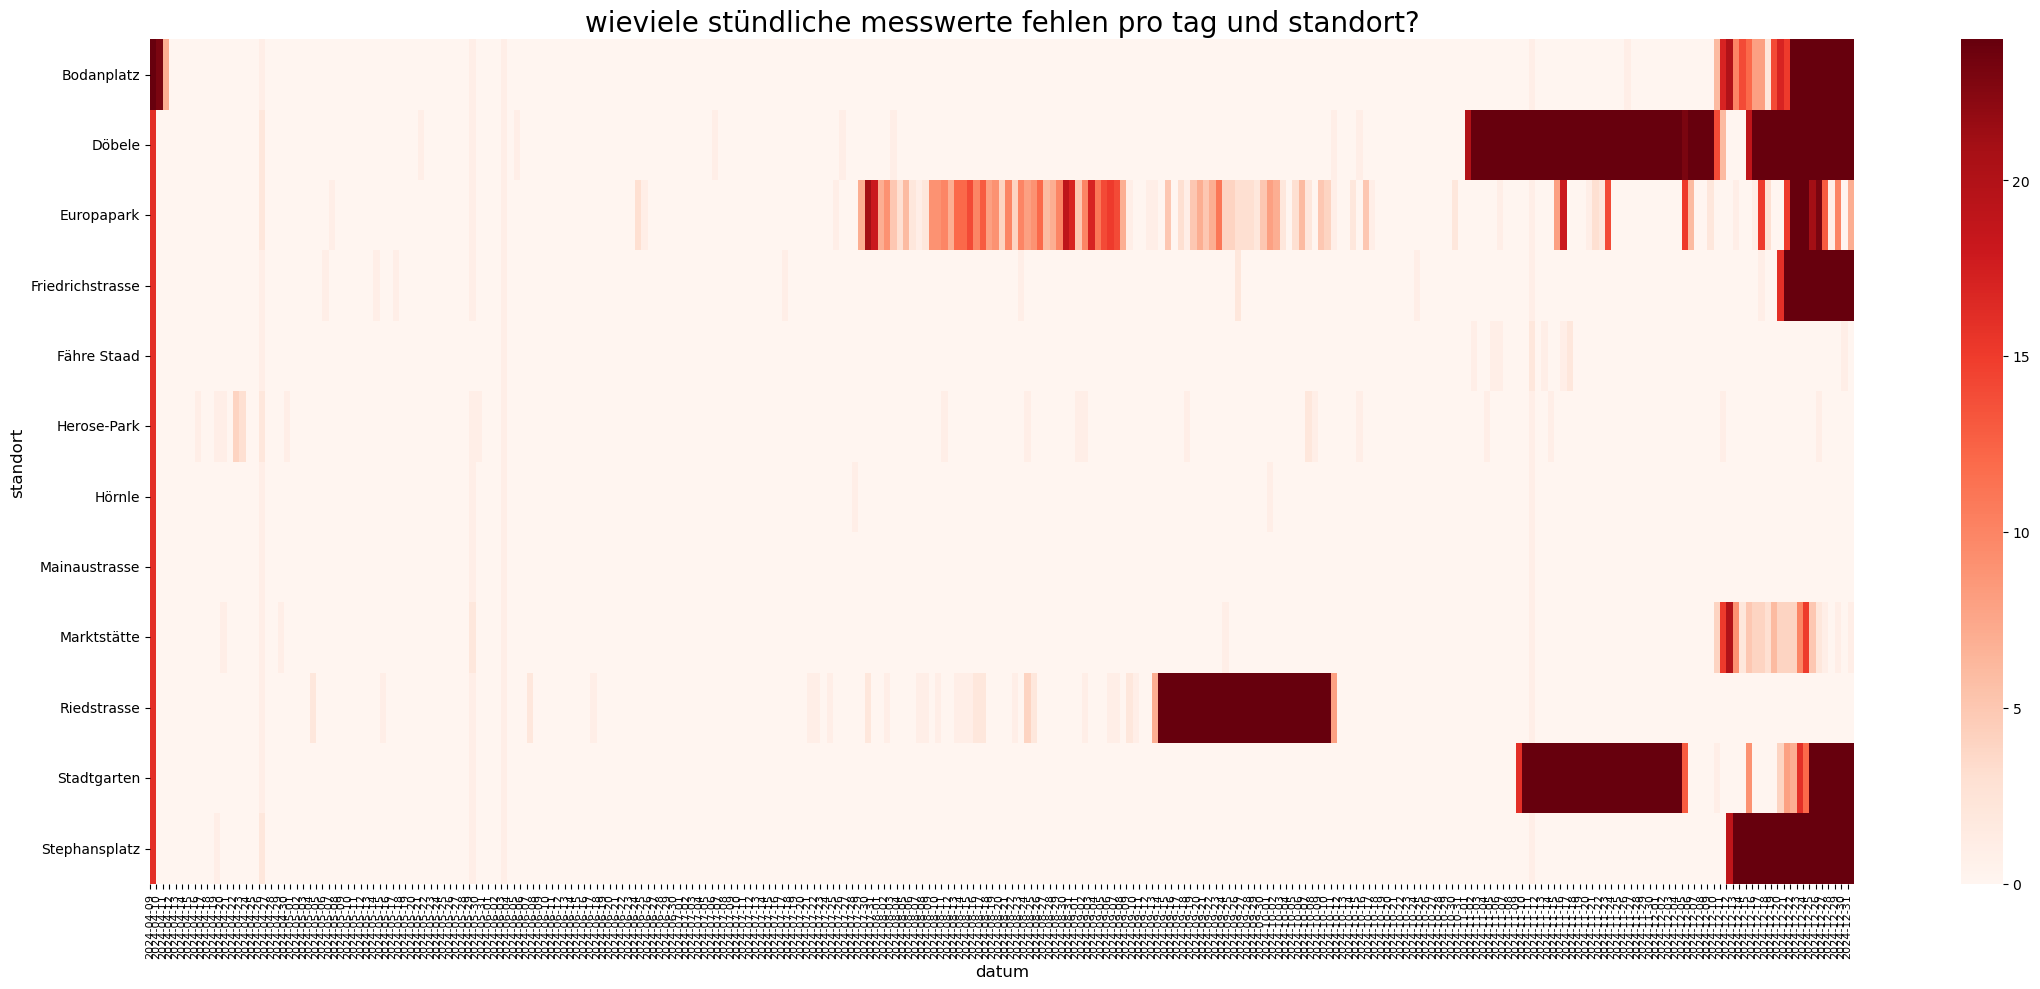

In [8]:
#count missing hours per day
missing_hours_per_day = ws_compl[ws_compl['temperature'].isna()] \
    .groupby(['name', 'date']) \
    .size() \
    .reset_index(name='missing_hours_per_day')

#merge with complete dataframe, missing hours = 0 if day is complete
all_combinations = ws_compl.reset_index()[['name', 'date']].drop_duplicates()
missing_hours_per_day = all_combinations.merge(missing_hours_per_day, on=['name', 'date'], how='left')
missing_hours_per_day['missing_hours_per_day'] = missing_hours_per_day['missing_hours_per_day'].fillna(0)

#pivot
data = missing_hours_per_day.pivot_table(index='name', columns='date', values='missing_hours_per_day')

#plot
plt.figure(figsize=(23, 10))
sns.heatmap(data, cmap='Reds', vmax=24, cbar=True)
plt.title('wieviele stündliche messwerte fehlen pro tag und standort?', fontsize=20)
plt.xlabel('datum', fontsize=12)
plt.ylabel('standort', fontsize=12)
plt.xticks(ticks=range(len(data.columns)), labels=data.columns.strftime('%Y-%m-%d'), rotation=90, fontsize=8)
plt.tight_layout()


In [9]:
#consequences of missing data: finding the warmest day based on median temperature  
max_temperature_day = ws_day.loc[ws_day['temperature'].idxmax()]
max_temperature_day 
#29.3 ist richtig viel als tagesschnitt - kann das sein?

name                             Europapark
date                             2024-08-11
atmosphericpressure                   971.0
precipitation                         27.89
relativehumidity                       51.6
temperature                            29.3
winddirection                         103.0
windspeedavg                            1.0
windspeedmax                            1.7
windspeedmin                            0.2
surfacetemperaturewintersense         32.71
temperaturewintersense                29.09
week_of_year                           32.0
Name: 594, dtype: object

In [10]:
#maxes = sorted(ws_day['temperature'], reverse=True)
#maxes[:40]

In [11]:
#check for missing hourly data for europpark on 11/08/24  
ws_compl[(ws_compl["name"] == "Europapark") & 
        (ws_compl["date"] == pd.to_datetime("2024-08-11"))]

,name,date,hour,atmosphericpressure,precipitation,relativehumidity,temperature,winddirection,windspeedavg,windspeedmax,windspeedmin,surfacetemperaturewintersense,temperaturewintersense,week_of_year
15768,Europapark,2024-08-11,0,974.80,27.89,79.60,21.70,240.0,0.50,0.90,0.10,23.11,20.52,32.0
15769,Europapark,2024-08-11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
15770,Europapark,2024-08-11,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
15771,Europapark,2024-08-11,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
15772,Europapark,2024-08-11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
15773,Europapark,2024-08-11,5,973.90,27.89,90.60,18.20,228.0,0.30,0.40,0.20,19.03,16.93,32.0
15774,Europapark,2024-08-11,6,974.10,27.89,94.10,17.70,251.0,0.20,0.40,0.10,18.71,16.56,32.0
15775,Europapark,2024-08-11,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
15776,Europapark,2024-08-11,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
15777,Europapark,2024-08-11,9,974.20,27.89,70.10,23.50,69.0,1.60,2.50,0.20,29.27,25.18,32.0


In [12]:
#tagesmedian verzerrt da vorallem kühlere nachtstunden fehlen

In [13]:
#another data quality issue: unplausible werte - 18 grad bodanplatz um 5uhr morgens im april? 
ws_compl[(ws_compl['date'].astype(str) == '2024-04-11') & (ws_compl['hour'] == 5)]


,name,date,hour,atmosphericpressure,precipitation,relativehumidity,temperature,winddirection,windspeedavg,windspeedmax,windspeedmin,surfacetemperaturewintersense,temperaturewintersense,week_of_year
29,Bodanplatz,2024-04-11,5,983.80,0.89,52.80,18.60,51.0,0.10,0.10,0.00,NaN,NaN,15.0
6437,Döbele,2024-04-11,5,983.70,22.67,95.00,3.20,210.0,0.10,0.20,0.00,NaN,NaN,15.0
12845,Europapark,2024-04-11,5,983.45,51.31,98.44,3.20,220.0,0.55,0.85,0.35,3.70,2.31,15.0
19253,Friedrichstrasse,2024-04-11,5,981.70,13.77,93.44,3.80,50.0,0.20,0.35,0.00,NaN,NaN,15.0
25661,Fähre Staad,2024-04-11,5,983.55,21.02,89.74,4.65,284.5,0.50,1.00,0.25,NaN,NaN,15.0
32069,Herose-Park,2024-04-11,5,983.90,12.65,96.64,4.20,315.5,0.25,0.45,0.15,NaN,NaN,15.0
38477,Hörnle,2024-04-11,5,983.15,0.00,96.40,4.30,267.5,0.55,0.75,0.25,NaN,NaN,15.0
44885,Mainaustrasse,2024-04-11,5,982.75,17.61,95.60,4.05,57.5,0.30,0.60,0.05,NaN,NaN,15.0
51293,Marktstätte,2024-04-11,5,984.10,41.97,87.00,4.95,221.0,0.60,0.95,0.15,5.29,4.22,15.0
57701,Riedstrasse,2024-04-11,5,983.50,0.45,97.00,2.50,110.0,0.40,0.70,0.20,NaN,NaN,15.0


In [14]:
#19.4 grad bodanplatz um 22.00 im april?
ws_compl[(ws_compl['date'].astype(str) == '2024-04-10') & (ws_compl['hour'] ==22)]

,name,date,hour,atmosphericpressure,precipitation,relativehumidity,temperature,winddirection,windspeedavg,windspeedmax,windspeedmin,surfacetemperaturewintersense,temperaturewintersense,week_of_year
22,Bodanplatz,2024-04-10,22,983.40,0.89,52.30,19.40,287.0,0.00,0.10,0.00,NaN,NaN,15.0
6430,Döbele,2024-04-10,22,983.35,22.67,79.09,7.10,217.5,0.10,0.40,0.00,NaN,NaN,15.0
12838,Europapark,2024-04-10,22,983.20,51.31,80.30,6.90,242.5,0.35,0.40,0.10,8.58,5.23,15.0
19246,Friedrichstrasse,2024-04-10,22,981.40,13.77,76.20,7.60,58.0,0.20,0.40,0.10,NaN,NaN,15.0
25654,Fähre Staad,2024-04-10,22,983.35,21.02,71.94,8.05,316.5,0.55,0.85,0.20,NaN,NaN,15.0
32062,Herose-Park,2024-04-10,22,983.50,12.65,74.39,8.00,281.0,0.30,0.70,0.10,NaN,NaN,15.0
38470,Hörnle,2024-04-10,22,982.90,0.00,74.50,7.30,277.0,0.35,0.60,0.05,NaN,NaN,15.0
44878,Mainaustrasse,2024-04-10,22,982.45,17.61,78.24,7.50,158.0,0.25,0.60,0.00,NaN,NaN,15.0
51286,Marktstätte,2024-04-10,22,983.75,41.97,72.44,8.85,48.5,0.25,0.65,0.05,9.22,8.01,15.0
57694,Riedstrasse,2024-04-10,22,983.20,0.45,83.65,6.25,59.0,0.20,0.30,0.10,NaN,NaN,15.0


#### Und jetzt?

In [15]:
#Möglichst langen Zeitraum mit möglichst vollständigen Daten rausschlagen?

        #Stationen mit häufigen Ausfällen entfernen
        #Vollständigkeitskriterium Zeit lockern (23h?)

#Oder einzelne relevante Tage heraussuchen, z.b. die wärmsten? -> beispielhaft plotten

In [16]:
#remove rows with nan in 'hour' column
ws_compl_ohne_na = ws_compl.dropna(subset=['temperature'])

#count unique hours per location and date, then filter for 24 hours available
ws_compl_ohne_na24 = ws_compl_ohne_na.groupby(['name', 'date'])['hour'].nunique()
ws_compl_ohne_na24 = ws_compl_ohne_na24[ws_compl_ohne_na24 == 24].reset_index()

#tage filtern an denen alle 12 locations complete 24-hour data haben
complete_days12 = ws_compl_ohne_na24.groupby('date')['name'].nunique()
complete_days12 = complete_days12[complete_days12 == 12].reset_index()

complete_days12

,date,name
0,2024-04-12,12
1,2024-04-13,12
2,2024-04-14,12
3,2024-04-15,12
4,2024-04-17,12
...,...,...
87,2024-10-26,12
88,2024-10-27,12
89,2024-10-28,12
90,2024-10-29,12


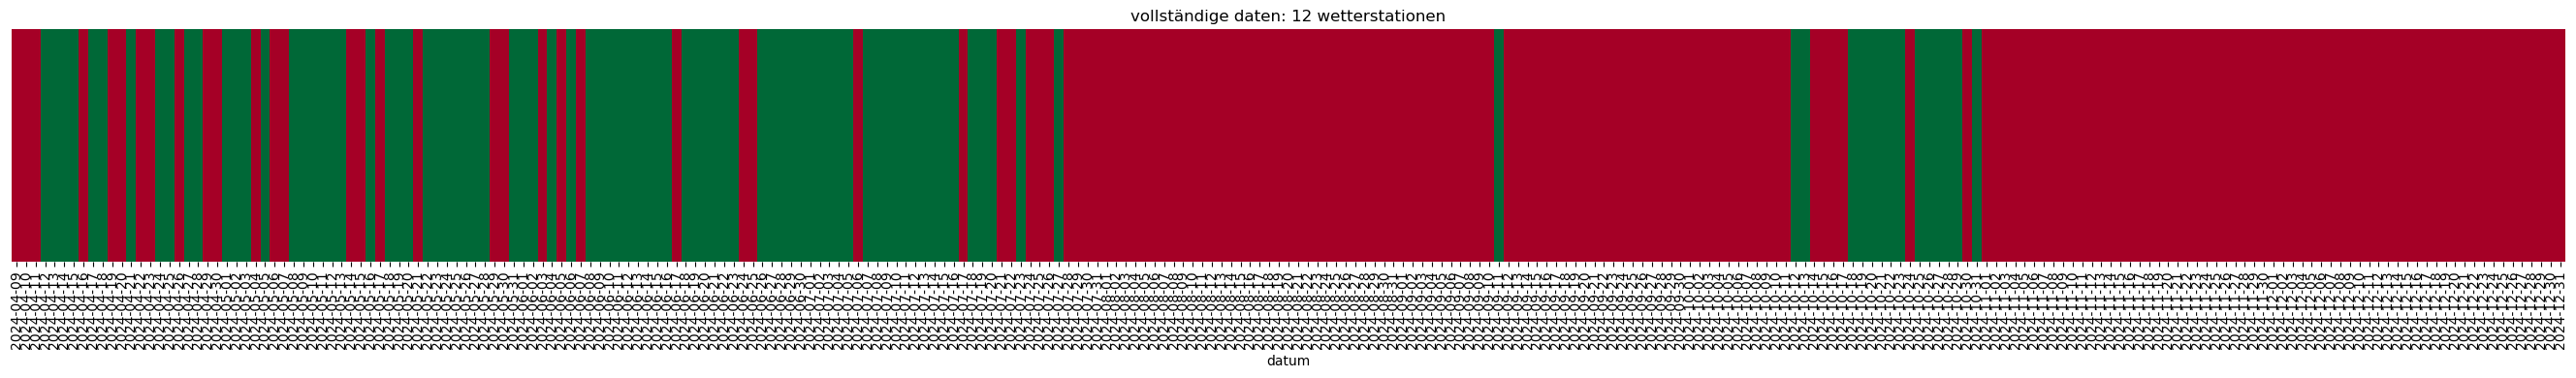

In [17]:
#"strengste version" -> 24h für 12 stationen
complete_days12['date'] = pd.to_datetime(complete_days12['date'])

#all dates between 04/09 and 12/31
all_days = pd.date_range(start='2024-04-09', end='2024-12-31', freq='D')
complete_days12_list = sorted(complete_days12['date'].tolist())

#array: 1 for complete days, 0 for other days
heatmap_data = [1 if day in complete_days_list12 else 0 for day in all_days]

#reshape data for heatmap
heatmap_data = np.array(heatmap_data).reshape(1, -1) 

#plot heatmap
plt.figure(figsize=(len(all_days) / 10, 4))  
sns.heatmap(heatmap_data, cmap="RdYlGn", cbar=False, xticklabels=all_days.strftime('%Y-%m-%d'), yticklabels=[], 
            linewidths=0, linecolor='black', cbar_kws={'ticks': [0, 1], 'label': 'data availability'})
plt.title('vollständige daten: 12 wetterstationen')
plt.xlabel('datum')
plt.ylabel('')
plt.xticks(rotation=90) 
plt.tight_layout()

In [18]:
#wieviele aneinanderhängende "vollständige" tage haben wir? filtern auf alle zeiträume mit min. 7 tagen
complete_days12 = complete_days12.sort_values(by='date')

#column day_diff
complete_days12['day_diff'] = complete_days12['date'].diff().dt.days

#compute periods
periods = []
start_date = complete_days12['date'].iloc[0]
period_start = start_date
count = 1  

#finde zeiträume mit lücke > 1 tag = zeitraum endet
for i in range(1, len(complete_days12)): 
    if complete_days12['day_diff'].iloc[i] > 1:  #abstand größer als 1 tag
        #insg >=7
        if count >= 7:
            periods.append((period_start, complete_days12['date'].iloc[i-1], count))
        period_start = complete_days12['date'].iloc[i]  
        count = 1 
    else:
        count += 1  
        
periods_df = pd.DataFrame(periods, columns=['start date', 'end date', 'duration'])
periods_df

,start date,end date,duration
0,2024-05-22,2024-05-28,7
1,2024-06-08,2024-06-16,9
2,2024-06-26,2024-07-05,10
3,2024-07-07,2024-07-16,10


#### Stationen filtern -> abändern code

In [22]:
#'komplette' zeiträume ohne Döbele
'''
Start Date   End Date  Duration
0 2024-05-18 2024-05-28        11
1 2024-06-08 2024-06-16         9
2 2024-06-26 2024-07-16        21
'''

#ohne Europapark
'''
0 2024-05-07 2024-05-13         7
1 2024-05-22 2024-05-28         7
2 2024-06-08 2024-06-16         9
3 2024-06-18 2024-07-05        18
4 2024-07-07 2024-07-16        10
5 2024-10-16 2024-10-23         8
6 2024-10-25 2024-10-31         7
'''

#ohne Riedstraße
'''
0 2024-05-22 2024-05-28         7
1 2024-06-06 2024-06-23        18
2 2024-06-26 2024-07-05        10
3 2024-07-07 2024-07-16        10
4 2024-07-18 2024-07-24         7
'''

#ohne Europapark, Riedstraße
'''
0  2024-05-07 2024-05-13         7
1  2024-05-22 2024-05-28         7
2  2024-06-06 2024-07-05        30
3  2024-07-07 2024-07-16        10
4  2024-07-18 2024-07-25         8
5  2024-08-04 2024-08-10         7
6  2024-08-12 2024-08-22        11
7  2024-08-25 2024-08-31         7
8  2024-09-03 2024-09-17        15
9  2024-10-16 2024-10-23         8
10 2024-10-25 2024-10-31         7
'''

#ohne Döbele, Europapark, Riedstraße
'''
0 2024-05-07 2024-05-13         7
1 2024-05-18 2024-05-28        11
2 2024-06-04 2024-07-16        43
3 2024-07-18 2024-07-27        10
4 2024-07-29 2024-08-10        13
5 2024-08-12 2024-08-22        11
6 2024-08-25 2024-08-31         7
7 2024-09-03 2024-09-17        15
8 2024-10-16 2024-10-23         8
9 2024-10-25 2024-11-01         8
'''

'\n0 2024-05-07 2024-05-13         7\n1 2024-05-18 2024-05-28        11\n2 2024-06-04 2024-07-16        43\n3 2024-07-18 2024-07-27        10\n4 2024-07-29 2024-08-10        13\n5 2024-08-12 2024-08-22        11\n6 2024-08-25 2024-08-31         7\n7 2024-09-03 2024-09-17        15\n8 2024-10-16 2024-10-23         8\n9 2024-10-25 2024-11-01         8\n'

#### Zeitraum Flexibilität

In [ ]:
#min 23h bei allen der 12 stationen
'''
start date   end date       duration
0 2024-04-12 2024-04-21     10
1 2024-04-27 2024-05-03      7
2 2024-05-05 2024-05-28     24
3 2024-05-30 2024-06-06      8
4 2024-06-08 2024-06-23     16
5 2024-06-25 2024-07-28     34
6 2024-10-17 2024-10-29     13
'''

#min 22h 
'''
0 2024-04-12 2024-04-21     10
1 2024-04-24 2024-06-23     61
2 2024-06-25 2024-07-28     34
3 2024-10-17 2024-10-31     15
'''


#### Both

In [ ]:
#min 23 h für 10 stationen (ohne Riedstraße, Europapark)
'''
start date   end date  duration
0 2024-04-12 2024-04-21        10
1 2024-04-27 2024-05-28        32
2 2024-05-30 2024-09-25       119
3 2024-09-27 2024-10-06        10
4 2024-10-08 2024-10-31        24
'''

In [ ]:
#vergleich automatisieren? was priorisieren? möglichst viele stationen drinbehalten? möglichst langer zeitraum?
#mlglichst viele tage im sommer?

[........]